# <b> Задание на ЛР 1 </b>
Испытатели выставили дрон на некотором расстоянии от стены. Оператор запустил дрон и просто нажал на кнопку "лететь вперёд". При этом, есть опеределённый угол, на который траектория коптера отклоняется от стены. Каждый момент времени дрон меряет свою скорость `V` и расстояние до стены `h` с некоторой погрешностью. Необходимо определить угол, на который отклоняется дрон от стены.  

<p align="center"><img src="task.png"> </p>

## Цель
Получить практические навыки в использовании вильтра Калмана
## Задача
Определить угол смещения траектории дрона, летящего вдоль стены.


# <b> Ход работы </b>
<!-- 1 <span style='color:#FF6600de'>|</span> -->


## 1 <span style='color:#FF6600de'>|</span> Дифференциальная модель системы <a name = "model"></a>

`Before we start...`  
Поскольку нас просят лишь УГОЛ отклонения, задачу целесообразно решать простой регрессией типа метода наименьших квадратов, но так как цель в том, чтобы научиться работать с фильтром Калмана, будем составлять дифференциальную модель и необходимые матрицы.

Задачу можно реашать различными способами, в зависимости от того, что воспринимать за искомую величину:
- координаты дрона ($x$, $y$)
- угол отклонения ($\alpha$)

И вроде бы, второй вариант кажется более привлекательным (так как одномерен), но, в сущности, имеем сложности с интерпретацией угловой скорости (мне не понятно, какую величину в такой модели брать в качестве радиуса). Поэтому я решил работать со вторым вариантом несмотря на то, что он даёт нам "лишнюю" информацию о положении дрона в пространстве.

Исходя из известных данных, можно построить следующее дифференциальное уравнение, описывающее систему:

$$
\begin{cases}
{x'=v_x+w_x} \\
{y'=v_y+w_y}
\end{cases}
$$

$$
\begin{cases}
{\frac{x_i-x_{i-1}}{\Delta t}=v_{x, i}+w_x} \\
{\frac{y_i-y_{i-1}}{\Delta t}=v_{y, i}+w_y}
\end{cases}
$$

$$
\begin{cases}
x_i = x_{i-1} + \Delta t v_{x, i} + \Delta t w_x \\
y_i = y_{i-1}+ \Delta t v_{y, i} + \Delta t w_y
\end{cases}
$$

<a id='model'></a>
Показания датчиков нам говорят лишь `линейную скорость` и `высоту`. Однако этой информации достаточно для определения координат дрона в каждый момент времени.

Выделим какой-нибудь промежуток времени $\Delta t$ и опишем модель на основе поведения дрона в это время:
- имеем точку A($x_{i-1}, y_{i-1}$) с показанием высоты $h_{i-1}$
- дрон летит в точку B($x_{i}, y_{i}$) с показанием высоты $h_{i}$ и показанием скорости $V_i$. Стоит отметить, что в точке B индекс у скорости именно `i` -- по определениу скорости через производную координаты по времени: $v_i = \frac{S_i-S_{i-1}} {t_{i}-t_{i-1}}$

<p align="center"><img src="model.png"> </p>

Тогда скорости по координатам `x` и `y` будут вычисляться по следующим уравнениям:

$v_{x, i} = \frac{\sqrt{(V_i \Delta t)^2 - \Delta h^2}}{\Delta t}$  
$v_{y, i} = \frac{\Delta h}{\Delta t}$

В итоге имеем следующую систему дифференциальных уравнений, описывающих задачу:

$$
\begin{cases}
x_i = x_{i-1} + \sqrt{(V_i \Delta t)^2 - \Delta h^2} + \Delta t w_x \\
y_i = y_{i-1}+ \Delta h + \Delta t w_y
\end{cases}
$$

Пришлось слегка изменить оригинальные входные данные -- теперь имеем не показания с датчиков скорости и расстояния от стены, а формулы $v_{x, i}$ и $v_{y, i}$. Но на решение это не сильно влияет -- можно сказать, что матричный вид системы упрощается, кстати о нём:

$$
\begin{pmatrix}
x_i \\
y_i
\end{pmatrix} = 


\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix} 

\begin{pmatrix}
x_{i-1} \\
y_{i-1}
\end{pmatrix} +


\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix} 

\begin{pmatrix}
\sqrt{(V_i \Delta t)^2 - \Delta h^2} \\
\Delta h
\end{pmatrix} +


\begin{pmatrix}
\Delta t & 0 \\
0 & \Delta t
\end{pmatrix} 

\begin{pmatrix}
w_x \\
w_y
\end{pmatrix}
$$

Угол теперь можно найти по формуле:

$$\alpha = arctg \left(\frac{\Delta y}{\Delta x} \right)$$

## 2 <span style='color:#FF6600de'>|</span> Реализация на Python 🐍

Импорт библиотек

In [23]:
import numpy as np
from numpy import matmul as mm, transpose as T
from numpy.linalg import inv
from scipy import integrate

import matplotlib.pyplot as plt
from math import sin, cos

%matplotlib inline

В блокноте удобнее работать с глобальными переменными, чем с ООП -- инициализируем всё необходимое

In [24]:
X = np.array([[]])       # вектор неизвестных (x y)
U = np.array([[]])       # вектор известных
F = np.array([[]])       # внешнее воздействие (F = m(a-g) -> a = (F+mg) / m)
G = np.array([[]])       # матрица для предыдущих априорных вычислений
P = np.array([[]])       # степень доверия состоянию
Q = np.array([[]])       # ковариация ошибок
Gamma = np.array([[]])   # матрица коэффициентов шума (сами шумы уже есть в наблюдении)
Z = np.array([[]])       # наблюдение
H = np.array([[]])       # связь X и Z
R = np.array([[]])       # ковариация ошибки измерений

ts = np.linspace(0.01, 8, 100) # времянной интервал

offset = -2 # начальное расстояние дрона от стены

clearMagnitudes = np.array([[]]) # "чистые" координаты (без шумов)
xs = np.array([])                # оценки ФК по координате X
ys = np.array([])                # оценки ФК по координате Y
Ks = []                          # коэффициенты Калмана

trustModel = 1 # коэффициент степени доверия модели
additiveErrorFlag = False # флаг наличия аддитивной погрешности

Реализация ФК в виде функции представлена ниже. Функция возвращает:
- апостериорную оценку координат дрона
- апостериорную оценку степени доверия текущему состоянию
- коэффициент Калмана

In [25]:
def kalman_filter(
    X=np.array([[]]),       # вектор неизвестных (x y)
    U=np.array([[]]),       # вектор известных
    F=np.array([[]]),       # внешнее воздействие (F = m(a-g) -> a = (F+mg) / m)
    G=np.array([[]]),       # матрица для предыдущих априорных вычислений
    P=np.array([[]]),       # степень доверия состоянию
    Q=np.array([[]]),       # ковариация ошибок
    Gamma=np.array([[]]),   # матрица коэффициентов шума (сами шумы уже есть в наблюдении)
    Z=np.array([[]]),       # наблюдение
    H=np.array([[]]),       # связь X и Z
    R=np.array([[]]),       # ковариация ошибки измерений
) -> (float, float, float):
    
    # X^- = (F X) + (G U)
    Xprior = mm(F, X) + mm(G, U)
    # P^- = (F P^^ F^T) + (Gamma Q Gamma^-1)
    Pprior = mm(mm(F, P), T(F)) + mm(mm(Gamma, Q), T(Gamma))
    
    # y = Z - (H X)
    y = Z - mm(H, Xprior)
    
    # S = (H P H^T) + R
    S = mm(mm(H, Pprior), T(H)) + R
    K = mm(mm(Pprior, T(H)), inv(S))
    
    Xposterior = Xprior + mm(K, y)
    Pposterior = mm((np.eye(len(X)) - mm(K, H)), Pprior)
    
    return Xposterior, Pposterior, K[0][0]

Функции, имитирующие показания датчиков без шума (будем играться с ними в тестировании)

In [26]:
def V(t):
    v = 1
    return v

def h(t):
    height =  - t*0.3 + offset
    return height

Функции для интегрирования (`odeint` работает не так, как я от него жду, поэтому пришлось написать свой решатель диффуров...)

In [27]:
def dh_(i):
    return h(ts[i]) - h(ts[i-1])

def gen_clear_xy():
    xs = [0]
    ys = [offset]
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1]
        xs.append(np.sqrt( (V(ts[i])*dt)**2 - dh_(i)**2 ))
        ys.append(dh_(i))
    
    xs = np.array(xs)
    ys = np.array(ys)
    
    xs = np.cumsum(xs)
    ys = np.cumsum(ys)
    
    return np.stack([xs, ys], axis=-1)

Функция извлечения угла

In [28]:
def get_angles(xs, ys):
    dxs = np.array([xs[i] - xs[i-1] for i in range(1, len(xs))])
    dys = np.array([ys[i] - ys[i-1] for i in range(1, len(ys))])
    return np.arctan(dys/dxs) * 180/np.pi

Генерируем временную последовательность (не с нуля, а то получим деление на ноль при попытке посчитать координату в нулевой момент времени)

In [29]:
ts = np.linspace(0.01, 8, 100)

Генерируем матрицы коэффициентов

In [30]:
def gen_model_matrices():
    global F, G, Gamma, Q, R
    
    dt = ts[1]-ts[0]
    
    F = np.array([
        [1, 0],
        [0, 1],
    ])
    
    G = np.array([
        [1, 0], 
        [0, 1],
    ])
    
    Gamma = np.array([
        [dt, 0 ], 
        [0,  dt],
    ])
    
    Q = np.eye(2)
    R = np.eye(2) * trustModel # чем больше R, тем больше фильтр доверяет модели

Генерируем измерения и всё, что с ними связано:

In [31]:
def gen_measurments():
    global clearMagnitudes, Z, H
    
    clearMagnitudes = gen_clear_xy()
    additiveError = 1
    W = np.random.rand(2, len(ts)) * additiveError*2
    if not additiveErrorFlag:
        W -= np.ones(len(ts)) * additiveError
    
    Z = np.array([
        clearMagnitudes[:, 0] + W[0, :],
        clearMagnitudes[:, 1] + W[1, :],
    ])
    
    H = np.array([
        [1, 0],
        [0, 1]
    ])

Итеративная фильтрация

In [32]:
def play_filter():
    global xs, ys, Ks
    
    Xi_1 = np.array([[Z[0][0]], [Z[1][0]]])
    Pi_1 = np.eye(2)

    xs = [Xi_1[0][0]]
    ys = [Xi_1[1][0]]
    Ks = []
    
    for i, t in enumerate(ts[1:], 1):
        dt = t - ts[i-1]
        dh = h(t) - h(ts[i-1])
        dV = V(t) - V(ts[i-1])
        
        Xi, Pi, K = kalman_filter(
            Xi_1,
            np.array([
                [np.sqrt( (V(t)*dt)**2 - dh**2)], # * np.sign(dV)],
                [dh],
            ]),
            F, G, Pi_1, Q, Gamma,
            np.array([
                [Z[0, i]],
                [Z[1, i]]
            ]),
            H, R 
        )
        
        xs.append(Xi[0][0])
        ys.append(Xi[1][0])
        Ks.append(K)
    
        Xi_1 = np.copy(Xi)
        Pi_1 = np.copy(Pi)

Графики для наглядности

In [33]:
def plt_trajectory():
    '''
    График траектории полёта дрона и угла смещения траектории:
    - истинные
    - построенные по измерениям датчиков
    - отфильтрованные ФК
    '''
    wall = [xs, np.zeros(len(ts))]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])
    ax[0].plot(
        clearMagnitudes[:, 0], clearMagnitudes[:, 1], 
        *Z, '--', 
        xs, ys, 
    )
    ax[0].plot(*wall, linewidth=10)
    ax[0].legend([
        'Истинная траектория',
        'Измерения датчиков',
        'Результат работы ФК',
        'Стена'
    ])
    ax[0].grid()
    
    clearAngles = get_angles(*np.transpose(clearMagnitudes, axes=(1, 0)))
    measuredAngles = get_angles(*Z)
    realAngles = get_angles(xs, ys)
    ax[1].plot(
        ts[1:], clearAngles,
        ts[1:], measuredAngles, '--',
        ts[1:], realAngles,
    )
    ax[1].legend([
        'Истинная траектория',
        'Измерения датчиков',
        'Результат работы ФК',
    ])
    ax[1].grid()
    
    plt.show()

def plt_Ks():
    '''Построение графика изменений коэффициента Калмана'''
    plt.figure(2)
    plt.plot(ts[1:], Ks)
    plt.legend(['Коэффициент Калмана'])
    plt.show()

Мэйн для удобства

In [34]:
def main():
    gen_model_matrices()
    gen_measurments()
    play_filter()
    plt_trajectory()
    plt_Ks()

## 3 <span style='color:#FF6600de'>|</span> Тестирование

Сначала с дефолтными параметрами

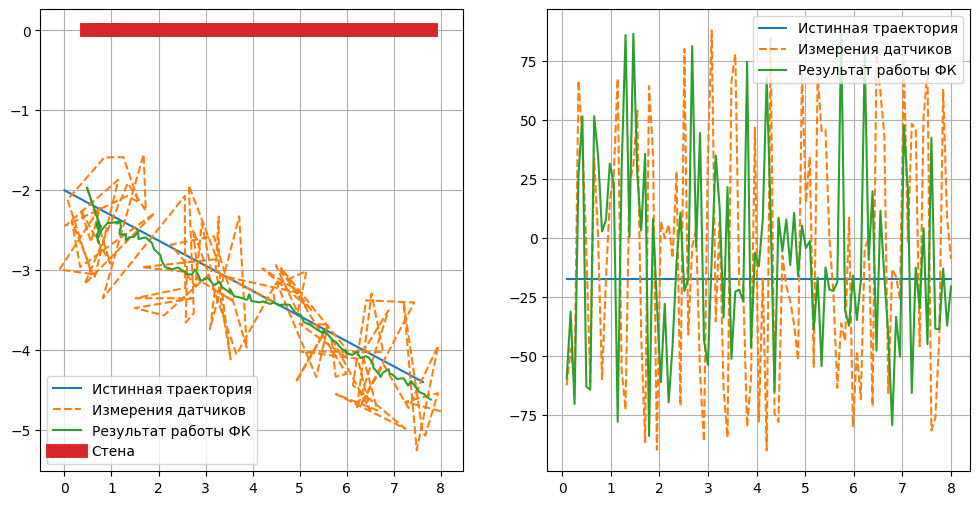

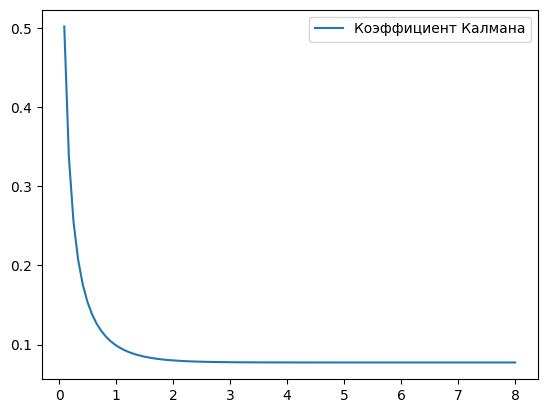

In [35]:
main()

Видим, что коэффийиент Калмана сходится -- модель описана верно.

Фильтрация координаты не плоха, но оценка угла выглядит плохо, а раз задача в том, чтобы предсказать угол, то ориентируемся больше на его график. Увеличиваем степень доверия к модели

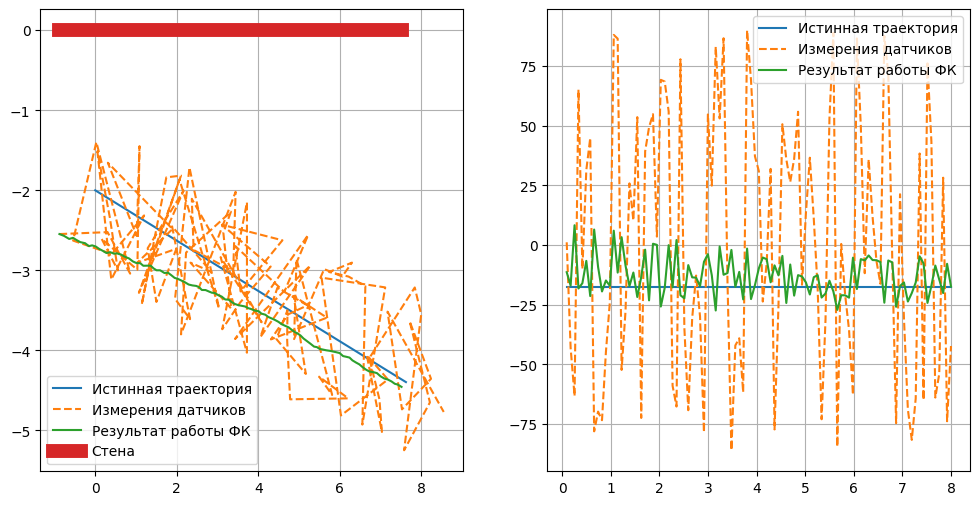

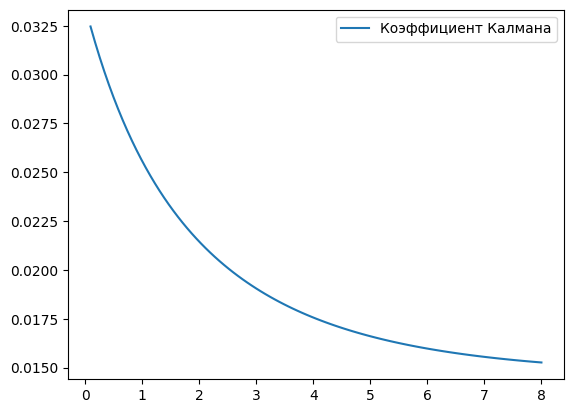

In [36]:
trustModel = 30
main()

Уже лучше, но всё ещё шумновато -- увеличим ещё степень доверия

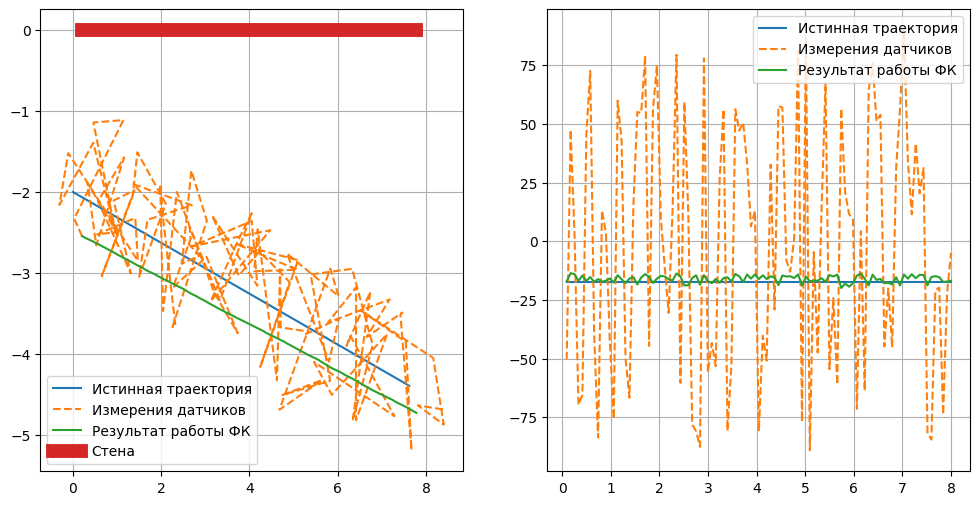

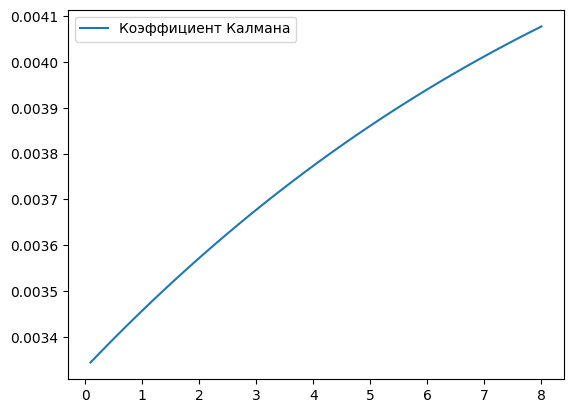

In [37]:
trustModel = 300
main()

Уже интереснее -- что можно сказать о результатах:
1. Оценка координат теперь сильно зависит от первых двух измерений -- они задают угол всей траектории. Поэтому имеем аддитивную погрешность в оценке траектории.
2. Коэффициент Калмана не успел сойтись, хотя видна его тенденция к схождению -- модель стала интертной.
3. Самое интересное -- угол мы предсказываем теперь очень точно!  
Объясняется легко -- угол зависит не от `абсолютных координат`, а лишь от `разности координат`, вот разность нам и убирает аддитивную ошибку.

По причине (3) даже если сам сенсор будет иметь аддитивную погрешность, на предсказание УГЛА это не повлияет (в отличие от координаты)


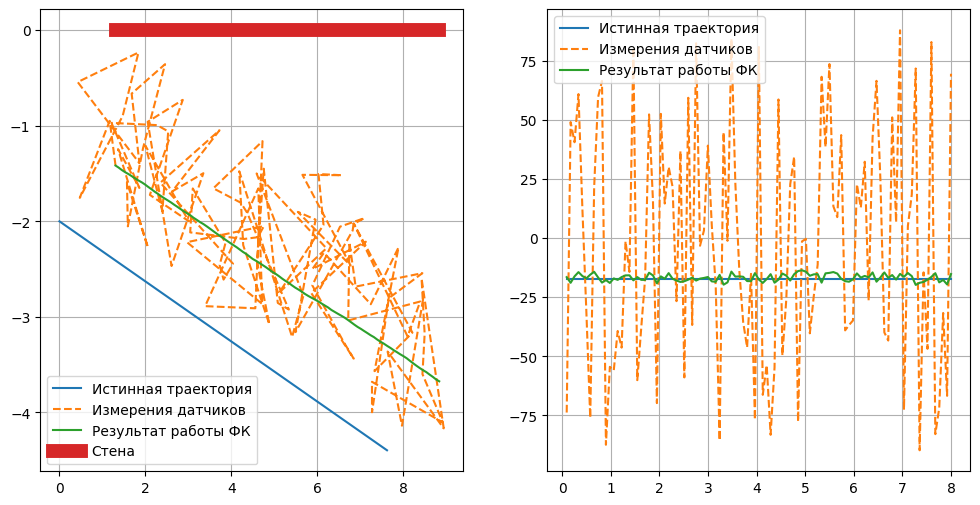

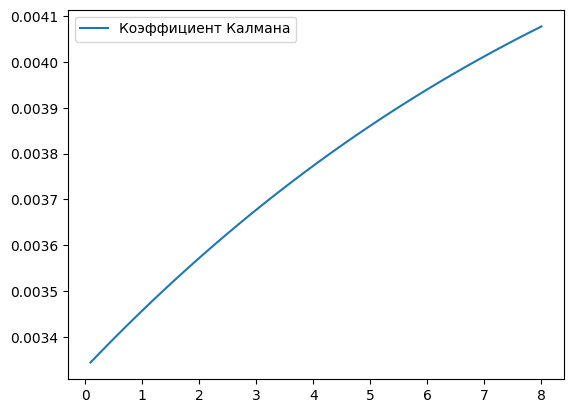

In [38]:
trustModel = 300
additiveErrorFlag = True
main()

Попробуем теперь поизменять показания с датчиков

Сначала изменим скорость. Тут надо быть аккуратным, так как при слишком маленьких скоростях получим невозможность построить треугольник из-за очень малого AB и большого BC ([какой треугольник?](#model)) -- этого модель не учитывает

In [39]:
def V(t):
    v = 100*t
    return v

def h(t):
    height =  -t*0.3 + offset
    return height

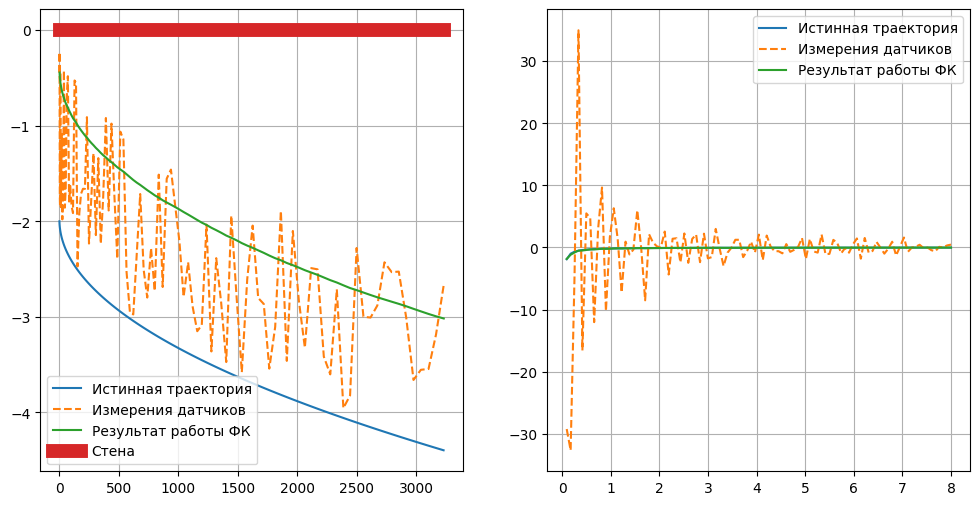

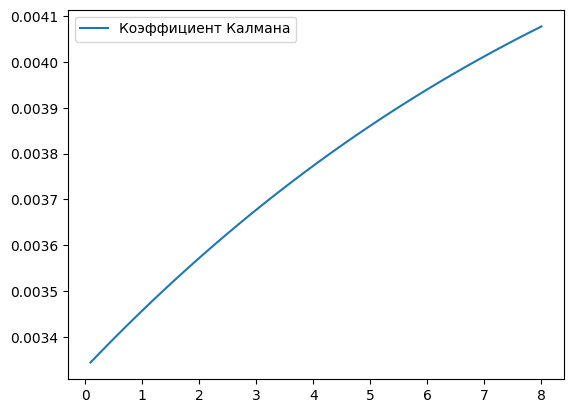

In [40]:
trustModel = 300
main()

Пусть показания расстояния будут квадратичными

In [41]:
offset = 1

def V(t):
    v = 100*t
    return v

def h(t):
    height = t**2*0.3 + offset
    return height

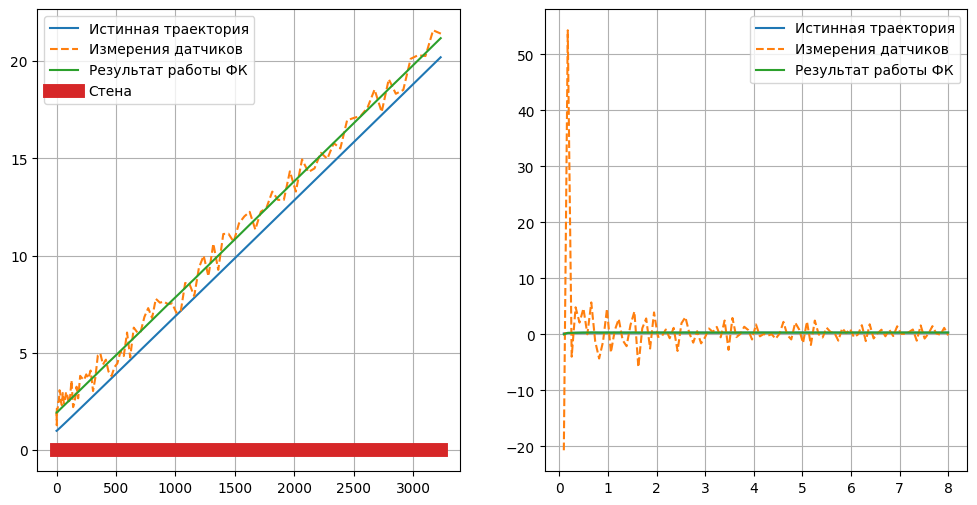

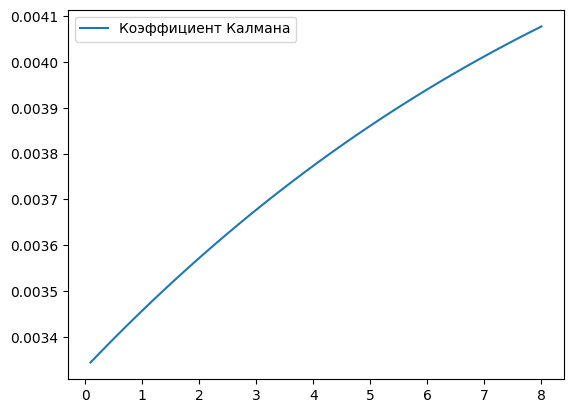

In [42]:
ts = np.linspace(0.01, 8, 100)
offset = 1
trustModel = 300
main()

Может показаться, что оценка расходится. Но это не совсем так. Чтобы доказать, что оценка сходится, нужно взять временной промежуток подлиннее

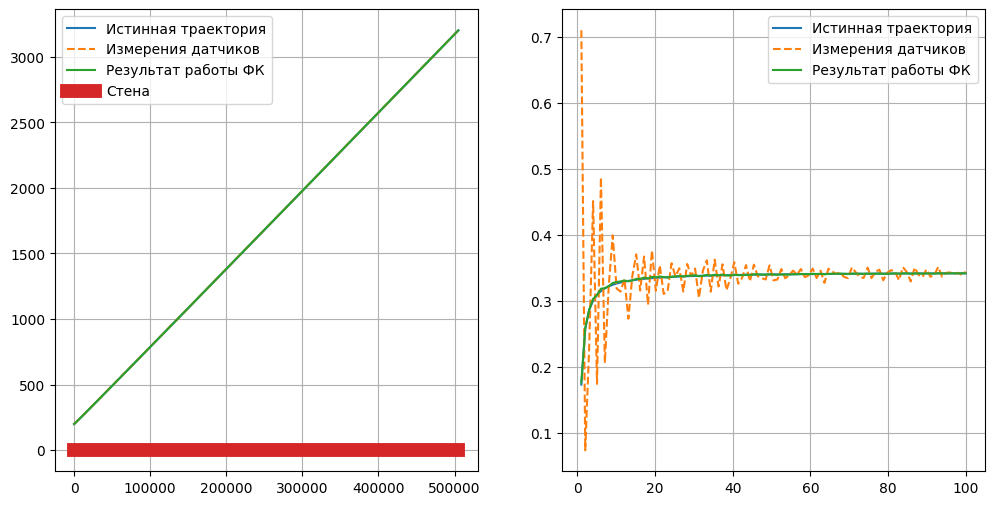

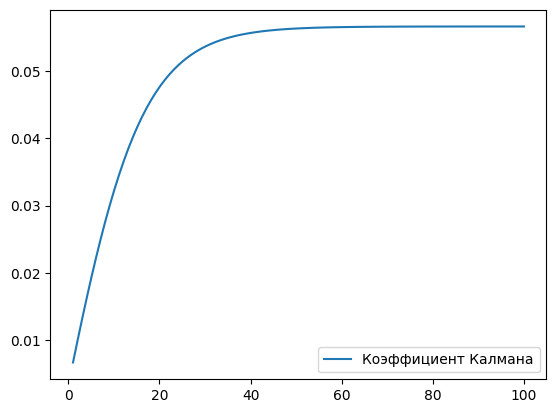

In [43]:
ts = np.linspace(0.01, 100, 100)
offset = 200
trustModel = 300
main()

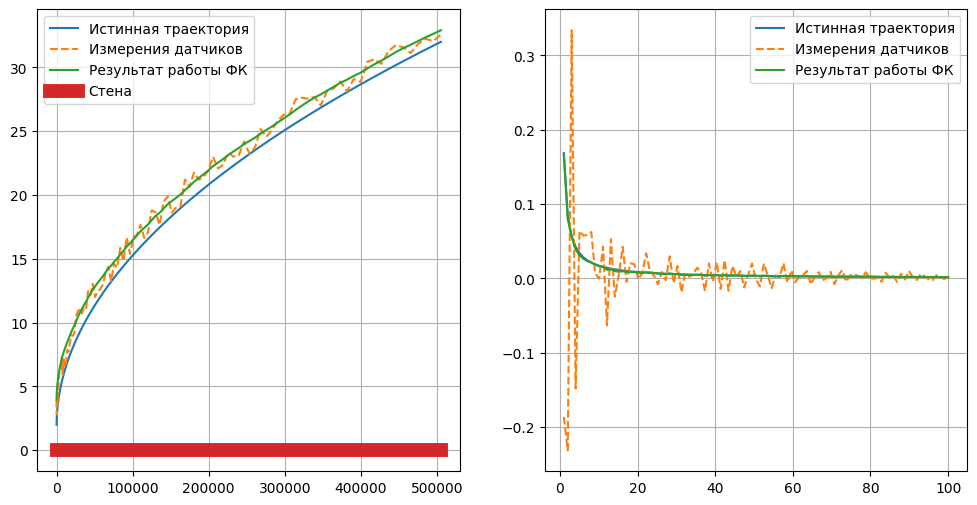

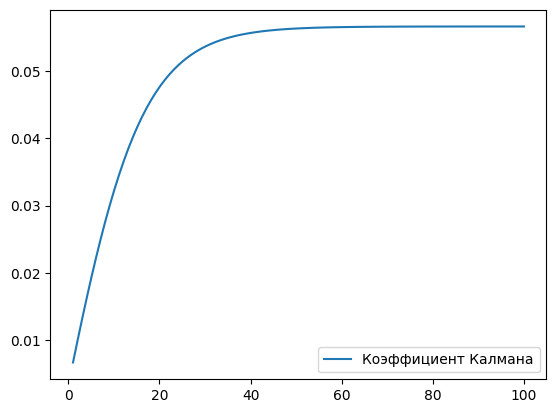

In [45]:
offset = 1

def V(t):
    v = 100 * -t
    return v

def h(t):
    height = t*0.3 + offset
    return height

ts = np.linspace(0.01, 100, 100)
offset = 2
trustModel = 300
main()

# <b>Выводы</b>

В ходе данной лабораторной работы мною были получены практические навыки в работе с фильтром Калмана:
- реализован ФК 
- построена дифференциальная модель системы
- модель реализована на Python
- все выкладки протестированы и объяснены
- аддитивная погрешность измерений не влияет на результат оценки угла наклона

Также возникли следующие трудности:
- не удалось составить модель, в которой в качестве неизвестной выступает угол наклона (неясно, что брать за радиус в определении угловой скорости -- т.е. как перевести линейную скорость в угловую)
- изначально посчитал, что корень в формуле скорости по X создаст проблемы (в виде модуля, сложных матриц и т. д.), реализовал через квадраты -- но реализовал криво (не учёл, что $(x_i-x_{i-1})^2 \not= x_i^2 - x_{i-1}^2$)
- odeint...

Помимо этого, повторюсь, задачу можно было реализовать и без ФК -- для определния общего угла траектории полёта хватит и простого метода наименьших квадратов по ихмерениям.